<a href="https://www.kaggle.com/code/stemosamaghandour/cmi-detect-behavior-with-sensor-data-by-stemer?scriptVersionId=252817720" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_inference_server.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/cmi_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/__init__.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/templates.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/base_gateway.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/relay.py
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/cmi-detect-behavior-with-sensor-data/kaggle_evaluation/core/__init__.py
/kaggle/input/cmi-detect-behav

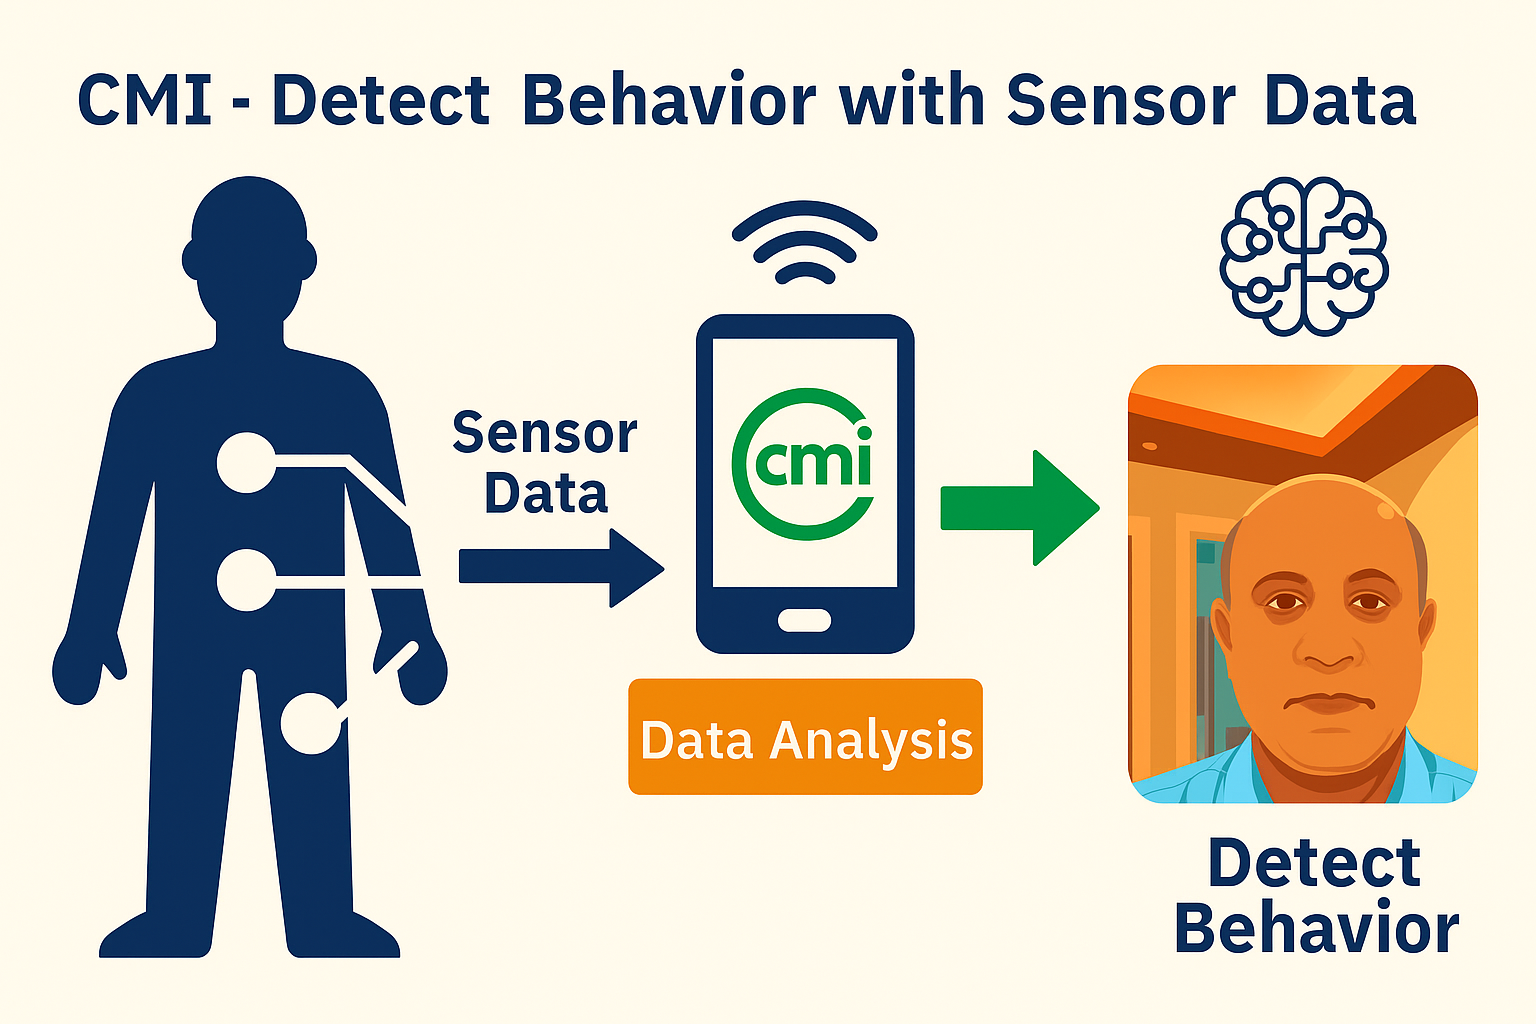

Here's a **flowchart** outlining the steps to solve the BFRB detection contest:

### **Flowchart for BFRB Detection Contest**  


### **Key Steps Explained:**  
1. **Data Loading & Preprocessing**  
   - Load IMU (acceleration, gyro), thermopile (temperature), and time-of-flight (proximity) data.  
   - Handle missing values, noise, and normalize data.  

2. **Exploratory Data Analysis (EDA)**  
   - Visualize sensor patterns for BFRB (hair pulling, skin picking) vs non-BFRB (adjusting glasses, waving).  
   - Check for class imbalance and sensor correlations.  

3. **Feature Engineering**  
   - Extract time-domain (mean, variance) and frequency-domain (FFT) features.  
   - Use sliding windows for segmentation.  
   - Fuse multi-sensor data (IMU + thermopile + ToF).  

4. **Model Selection**  
   - Test traditional ML (Random Forest, XGBoost) and deep learning (LSTM, CNN).  
   - Optimize for both IMU-only and full-sensor scenarios.  

5. **Evaluation**  
   - Use **Macro F1** (average of binary F1 and gesture-wise F1).  
   - Validate on unseen body positions (lying, sitting).  

6. **Submission**  
   - Format predictions for `sequence_id` and submit via the competition’s API.  

### **Critical Considerations:**  
- **Sensor Fusion vs IMU-only:** The model must perform well when tested on both partial (IMU) and full sensor data.  
- **Generalization:** Ensure robustness across different body positions (e.g., lying vs sitting).  
- **Real-world Impact:** The solution should justify whether thermopiles/ToF sensors improve detection.  

Would you like a more detailed breakdown for any specific step?

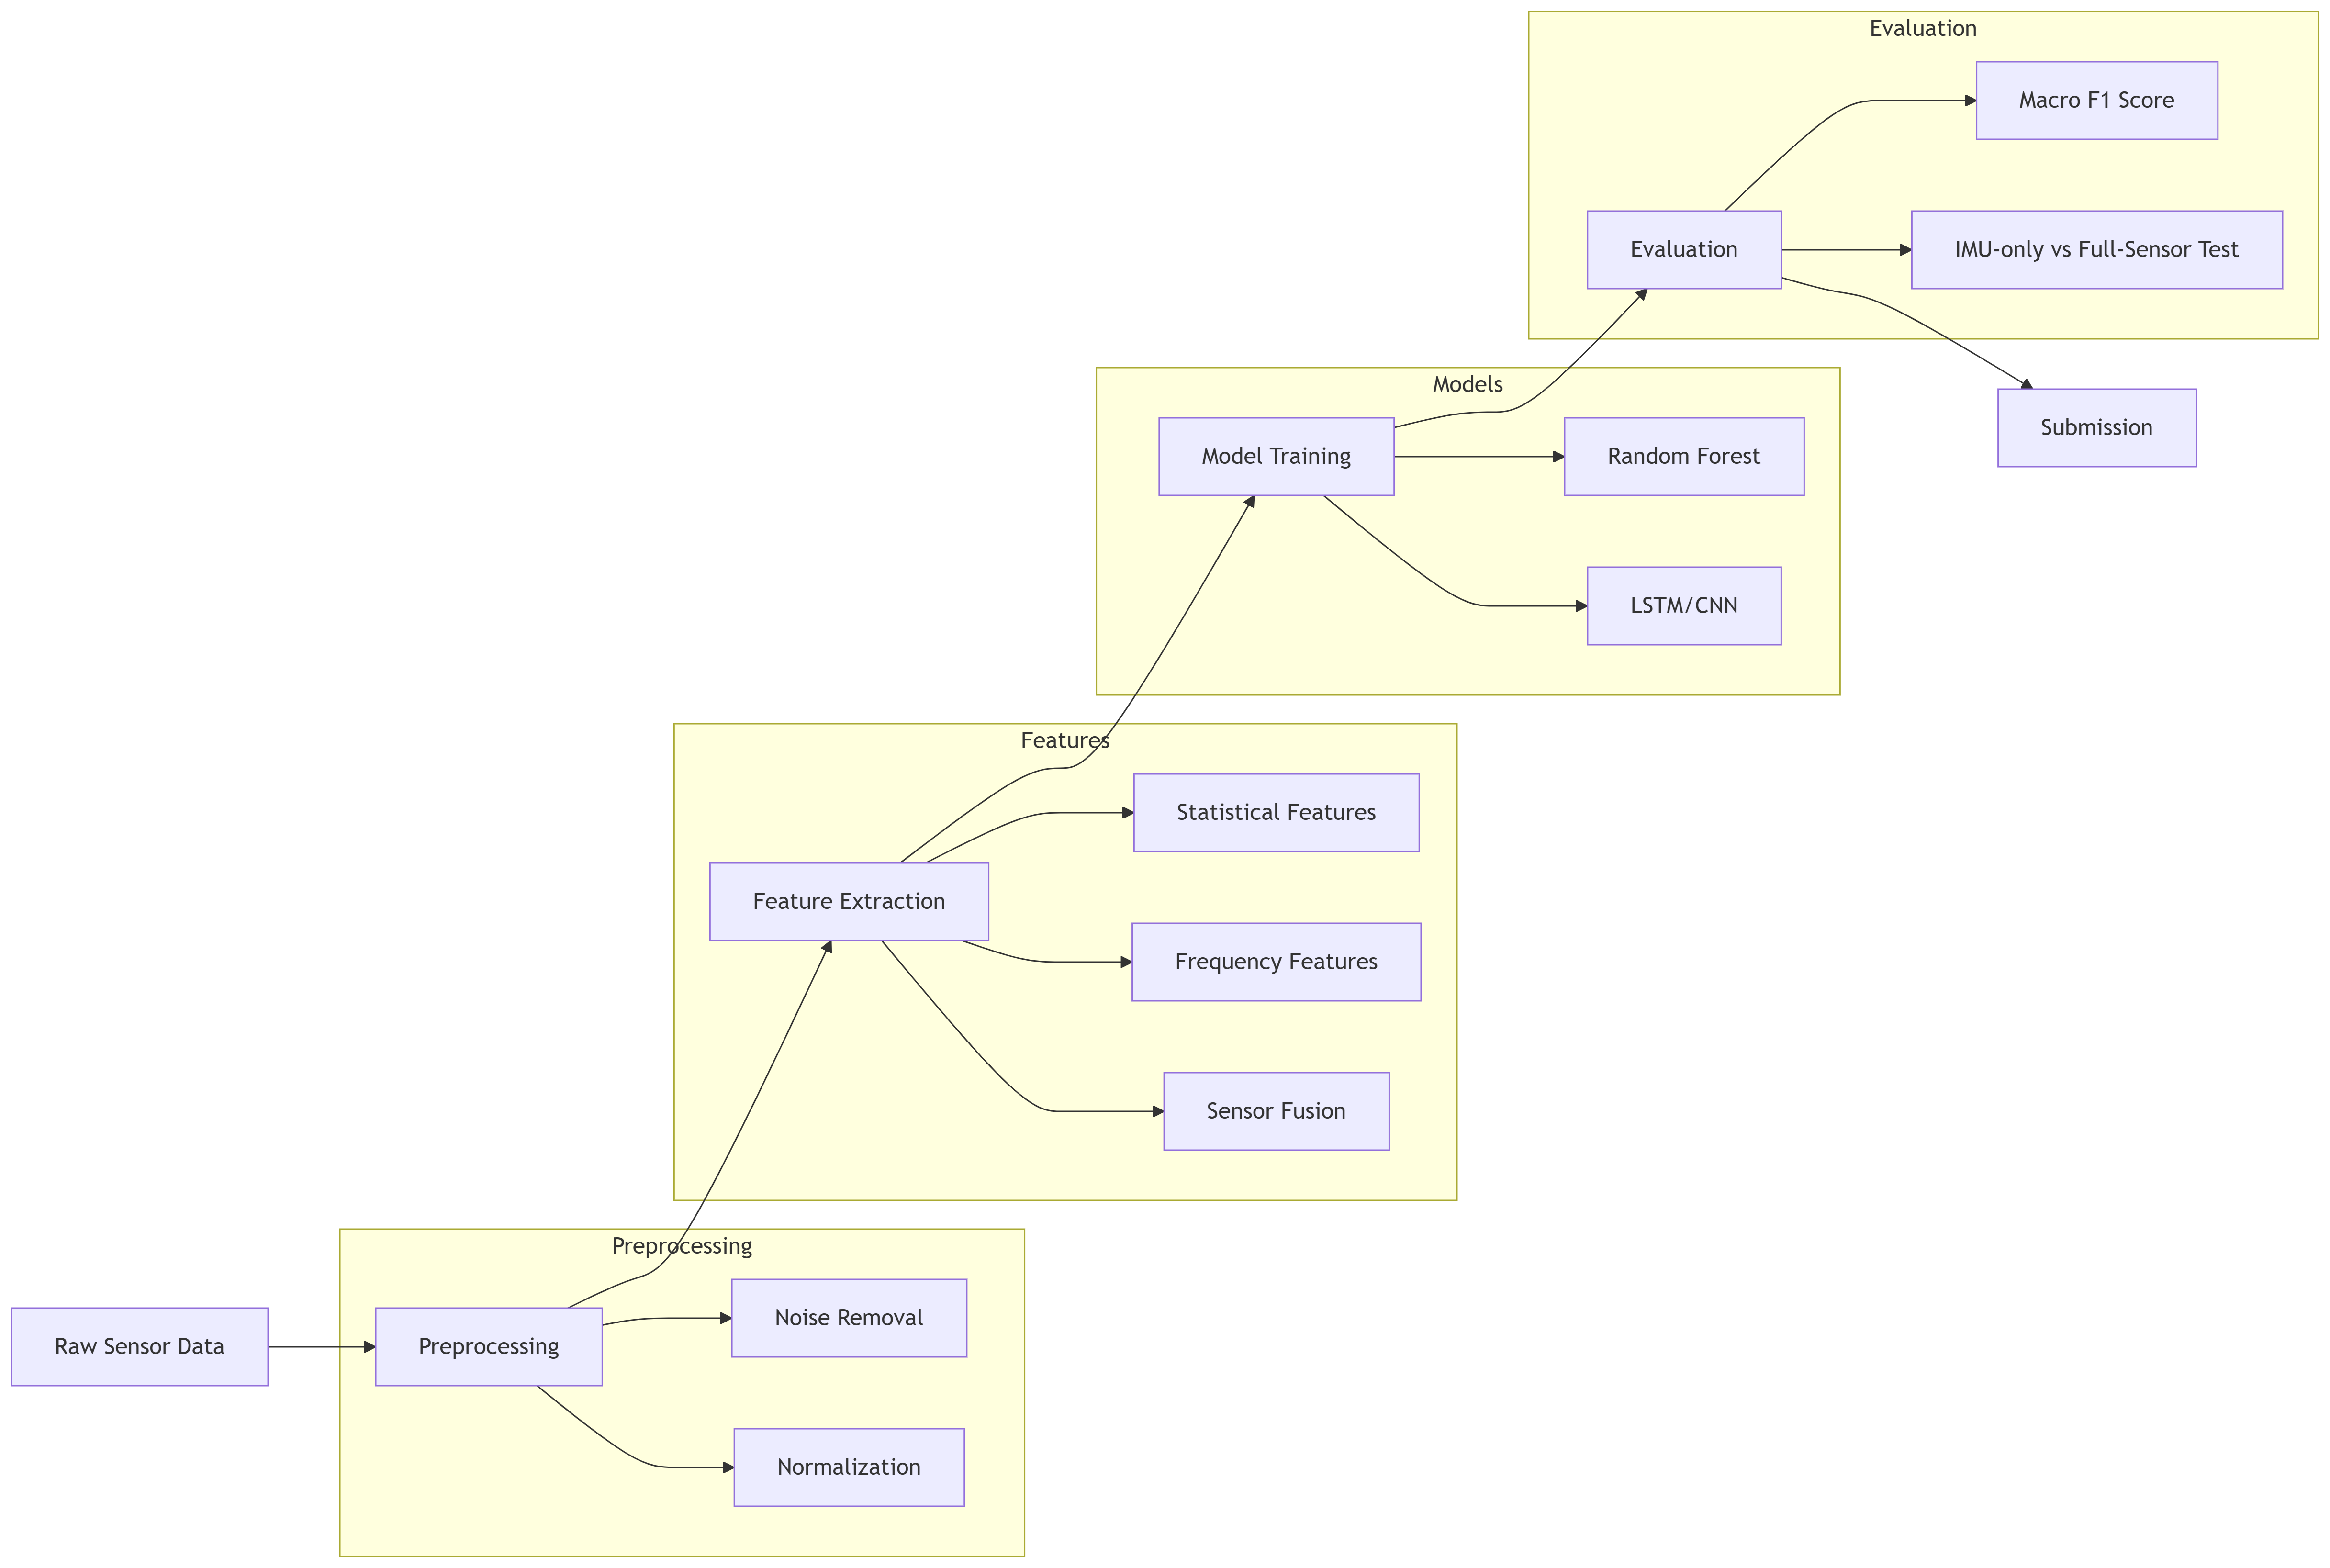

In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')



In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

train="/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv"
test="/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv"
train_path="/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv"
test_path="/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv"

In [83]:
#print(train.columns)

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# ----------------------------
# 1. Data Loading - Fixed Version
# ----------------------------
def load_data():
    """Load data from actual CSV files"""
    train = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")  # Replace with your actual path
    test = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")    # Replace with your actual path
    return train, test

# Load data correctly
train, test = load_data()  # No arguments needed now

# ----------------------------
# 2. Feature Engineering (Optimized)
# ----------------------------
def extract_features(df):
    sensors = ['tof_5_v54', 'tof_5_v55', 'tof_5_v56', 'tof_5_v57', 'tof_5_v58',
       'tof_5_v59']
    grouped = df.groupby('sequence_id')
    
    # Modern pandas aggregation
    features = grouped[sensors].agg(['mean', 'std', 'max', 'min'])
    features.columns = [f'{col[0]}_{col[1]}' for col in features.columns]
    
    # Add frequency features
    for sensor in ['acc_x', 'acc_y', 'acc_z']:
        fft = grouped[sensor].apply(lambda x: np.abs(np.fft.fft(x)[1:5]))
        features[f'{sensor}_fft_mean'] = fft.apply(np.mean)
        features[f'{sensor}_fft_std'] = fft.apply(np.std)
    
    # Add other sensors if available
    for sensor in df.columns:
        if 'thermopile' in sensor:
            features[f'{sensor}_mean'] = grouped[sensor].mean()
        if 'tof' in sensor:
            features[f'{sensor}_max'] = grouped[sensor].max()
    
    return features



In [81]:
# ----------------------------
# 3. Model Pipeline
# ----------------------------
# Encode gestures
le = LabelEncoder()
train['gesture'] = le.fit_transform(train['gesture'])

# Generate features
X_train = extract_features(train)
y_train = train.groupby('sequence_id')['gesture'].first()

# LightGBM training (same as before)
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# ... (rest of your training/evaluation code)

In [70]:
 #Cross-validation
skf = StratifiedKFold(n_splits=5)
f1_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val)
    #,verbose_eval=False
    model = lgb.train(params, train_data, valid_sets=[val_data])
    preds = model.predict(X_val).argmax(axis=1)
    f1 = f1_score(y_val, preds, average='macro')
    f1_scores.append(f1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77343
[LightGBM] [Info] Number of data points in the train set: 6520, number of used features: 344
[LightGBM] [Info] Start training from score -2.546260
[LightGBM] [Info] Start training from score -2.550182
[LightGBM] [Info] Start training from score -3.922817
[LightGBM] [Info] Start training from score -2.548219
[LightGBM] [Info] Start training from score -2.544305
[LightGBM] [Info] Start training from score -3.922817
[LightGBM] [Info] Start training from score -2.544305
[LightGBM] [Info] Start training from score -2.544305
[LightGBM] [Info] Start training from score -3.930599
[LightGBM] [Info] Start training from score -2.544305
[LightGBM] [Info] Start training from score -2.544305
[LightGBM] [Info] Start training from score -3.922817
[LightGBM] [Info] Start training from score -2.839830
[LightGB

In [82]:
print(f"Mean CV Macro F1: {np.mean(f1_scores):.4f}")

# Train final model
final_model = lgb.train(params, lgb.Dataset(X_train, label=y_train))

# ----------------------------
# 4. Inference & Submission
# ----------------------------
def prepare_submission(test):
    X_test = extract_features(test)
    preds = final_model.predict(X_test).argmax(axis=1)
    submission = test[['sequence_id']].drop_duplicates()
    submission['gesture'] = le.inverse_transform(preds)
    return submission

submission = prepare_submission(test)
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

Mean CV Macro F1: 0.3930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79182
[LightGBM] [Info] Number of data points in the train set: 8151, number of used features: 344
[LightGBM] [Info] Start training from score -2.547558
[LightGBM] [Info] Start training from score -2.549126
[LightGBM] [Info] Start training from score -3.924492
[LightGBM] [Info] Start training from score -2.547558
[LightGBM] [Info] Start training from score -2.544428
[LightGBM] [Info] Start training from score -3.924492
[LightGBM] [Info] Start training from score -2.544428
[LightGBM] [Info] Start training from score -2.544428
[LightGBM] [Info] Start training from score -3.924492
[LightGBM] [Info] Start training from score -2.544428
[LightGBM] [Info] Start training from score -2.544428
[LightGBM] [Info] Start training from score -3.924492
[LightGBM] [Info] Start training from